In [28]:
import hilbert
import numpy as np
import matplotlib.pyplot as plt

import bencodepy
import PIL.Image
import PIL.ImageChops
import struct
import zstandard
from tqdm import tqdm

In [29]:
dims = 16
N = 2**dims * 2**dims

N, 2**dims

(4294967296, 65536)

In [30]:
# coords = hilbert.decode(np.arange(N), 2, dims)

In [31]:
img = np.full((2**dims, 2**dims), False)

In [32]:
# 1899800377
# 4 294 967 296
# 2**32

In [34]:
input_filename = '../data/aa_isbn13_codes_20241204T185335Z.benc.zst'

isbn_data = bencodepy.bread(zstandard.ZstdDecompressor().stream_reader(open(input_filename, 'rb')))

In [35]:
packed_isbns_binary = isbn_data[b'gbooks']
packed_isbns_ints = struct.unpack(f'{len(packed_isbns_binary) // 4}I', packed_isbns_binary)
isbn_streak = True # Alternate between reading `isbn_streak` and `gap_size`.
position = 0 # ISBN (without check digit) is `978000000000 + position`.

for value in tqdm(packed_isbns_ints):
    # print(f"value: {value}", end="")
    # if position > 129_000_000:
        # print(position)
        # break
    if isbn_streak:
        # locs = coords[position:position+value]
        locs = hilbert.decode(np.arange(position, position+value), 2, dims)
        img[locs[:, 0], locs[:, 1]] = True
        position += value
    else: # Reading `gap_size`.
        position += value
    isbn_streak = not isbn_streak

100%|██████████| 44814789/44814789 [1:19:59<00:00, 9338.05it/s] 


In [36]:
position
1_899_800_377

1899800377

In [37]:
# img = ((2**dims, 2**dims), False)
# img = np.random.choice([True, False], size=(2**12, 2**12))

from PIL import Image
from matplotlib import cm
im = Image.fromarray(img)
im.save(f"image_{N}.png")

In [ ]:
import pyvips
top = img[:img.shape[0]//2, :]
image = pyvips.Image.new_from_array(np.invert(top))
tilesize = 4096
q=100
image.dzsave(
    f"../visualization/public/zoomify/gbooks_top_q{q}_N{N}_t{tilesize}_png_i", 
    layout="zoomify",
    # compression=compression,
    tile_size=tilesize,
    suffix=f".png[Q={q}]",
    # properties=False,
    # container="zip",
    # strip=True,
    # background=0
    # depth="one"
)

In [61]:
# there is no content on the lower half!
img[img.shape[0]//2:, :].max()

np.False_

In [ ]:
img[]

In [46]:
img.dtype

dtype('bool')

In [15]:
import shapely
from shapely import Polygon, unary_union
from shapely.geometry import mapping
from shapely import LineString, Polygon, simplify

import json

In [16]:
polycoords = coords[5:15000]
# print(polycoords)

img[polycoords[:, 0], polycoords[:, 1]]

pixel_squares = [Polygon([
    (x, y),
    (x+1, y),
    (x+1, y+1),
    (x, y+1)
]) for x, y in polycoords]

# Combine all squares into one unified shape
combined_shape = unary_union(pixel_squares)



combined_shape

simplified = simplify(combined_shape, tolerance=0)
# shapely.Polygon(polycoords)
simplified, combined_shape

(<POLYGON ((0 9, 0 64, 6 64, 6 68, 4 68, 4 72, 8 72, 8 80, 16 80, 16 96, 32 9...>,
 <POLYGON ((0 9, 0 10, 0 11, 0 12, 0 13, 0 14, 0 15, 0 16, 0 17, 0 18, 0 19, ...>)

In [17]:
len(simplified.exterior.coords)

20

In [19]:
geojson_shape = mapping(simplified)

geojson_feature = {
    "type": "Feature",
    "geometry": geojson_shape,
    "properties": {}  # Add any custom properties here
}

# Wrap it in a FeatureCollection
geojson_feature_collection = {
    "type": "FeatureCollection",
    "features": [geojson_feature]
}

# Save to a .geojson file
with open("geo.json", "w") as f:
    json.dump(geojson_feature_collection, f)

print("GeoJSON file saved as 'pixel_shape.geojson'")

GeoJSON file saved as 'pixel_shape.geojson'


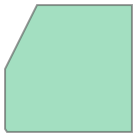

In [20]:
# Compute the convex hull for a tight-fitting polygon
hull = shapely.convex_hull(shapely.MultiPoint(polycoords))

# Extract the vertices of the convex hull
# hull_points = polycoords[hull]

# # Create a Shapely polygon from the hull points
# tight_polygon = shapely.Polygon(hull_points)
hull

In [21]:
polycoords

array([[ 0,  3],
       [ 1,  3],
       [ 1,  2],
       ...,
       [ 7, 64],
       [ 6, 64],
       [ 6, 65]], shape=(14995, 2), dtype=uint64)

978000000000
0
978100000000
100000
978200000000
200000
978300000000
300000
978400000000
400000
978500000000
500000
978600000000
600000
978601000000
601000
978602000000
602000
978603000000
603000
978604000000
604000
978605000000
605000
978606000000
606000
978607000000
607000
978608000000
608000
978609000000
609000
978611000000
611000
978612000000
612000
978613000000
613000
978614000000
614000
978615000000
615000
978616000000
616000
978617000000
617000
978618000000
618000
978619000000
619000
978620000000
620000
978621000000
621000
978622000000
622000
978623000000
623000
978624000000
624000
978625000000
625000
978626000000
626000
978627000000
627000
978628000000
628000
978629000000
629000
978630000000
630000
978631000000
631000
978650000000
650000
978700000000
700000
978800000000
800000
978810000000
810000
978820000000
820000
978830000000
830000
978840000000
840000
978850000000
850000
978860000000
860000
978870000000
870000
978880000000
880000
978890000000
890000
978900000000
900000
97891

In [38]:
# Original dictionary
data = {
    '978-0': 'English language',
    '978-1': 'English language',
    '978-2': 'French language',
    '978-3': 'German language',
    '978-99993': 'Mauritius',
    '978-4': 'Japan',
    '979-12': 'Italy',
    '979-8': 'United States'
}

# Mapping of group identifier lengths
group_lengths = {
    '978-0': 1,
    '978-1': 1,
    '978-2': 1,
    '978-3': 1,
    '978-99993': 5,
    '978-4': 1,
    '979-12': 2,
    '979-8': 1
}

processed = {}
for key, value in data.items():
    # Remove the dash and split into parts
    prefix, group = key.split('-')
    
    # Pad group identifier to its proper length
    group_length = group_lengths[key]
    padded_group = f"{group:0<{group_length}}"
    
    # Concatenate the prefix and padded group
    padded_key = f"{prefix}{padded_group:0<9}"  # Pad with zeros to make up 12 digits
    padded_key_int = int(padded_key) - 978_000_000_000  # Subtract base value
    
    # Store the processed key with its value
    processed[padded_key_int] = value

print(processed)


{0: 'English language', 100000000: 'English language', 200000000: 'French language', 300000000: 'German language', 999930000: 'Mauritius', 400000000: 'Japan', 1120000000: 'Italy', 1800000000: 'United States'}
